### Imports

In [1]:
from analyze_results import *
from getting_examples import *
from predict_activations import *
from utils import *
import json
import pprint

### Run an experiment

In [2]:
# with open(f'feats.json', 'r') as file:
#     feature_data = json.load(file)

# results = run_experiments(
#     num_features=2, 
#     feature_data=feature_data,
#     test_pos=5, # Experiment with
#     test_neg=5, # Experiment with
#     show_pos=0, # Experiment with
#     show_neg=0, # Experiment with
#     neg_type='others', # Experiment with
#     binary_class=True, # Experiment with
#     show_max_token=False, # Experiment with
#     num_completions=1, # Experiment with
#     debug=False, 
#     randomize_pos=True, 
#     seed=42,
#     save_location='test'
# )

# # the run_experiments function automatically saves results to results/exp_{timestamp}.json
# pprint.pprint(results)

### Load a past result file

In [3]:
# json_data = load_json_results('results/exp_1715322008.339694.json')
# pprint.pprint(json_data)

### Do analysis on loaded json_data

In [4]:
json_data_binary = load_json_results('results/binary_test/exp_binary_others.json')
json_data_continuous = load_json_results('results/binary_test/exp_continuous_others.json')

In [5]:
binary_preds = [json_data_binary['results'][i]['gpt_predictions'] for i in range(len(json_data_binary['results']))]
continuous_preds = [json_data_continuous['results'][i]['gpt_predictions'] for i in range(len(json_data_continuous['results']))]

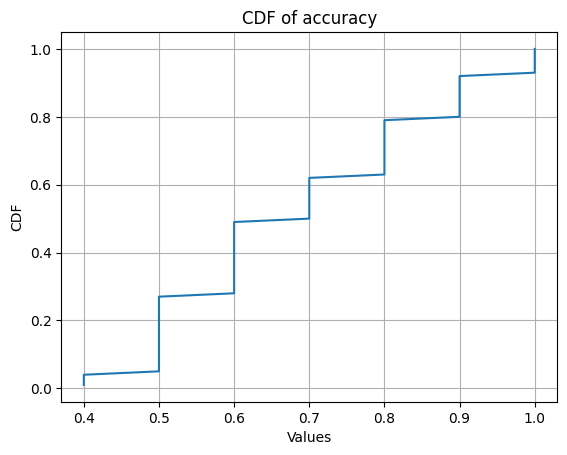

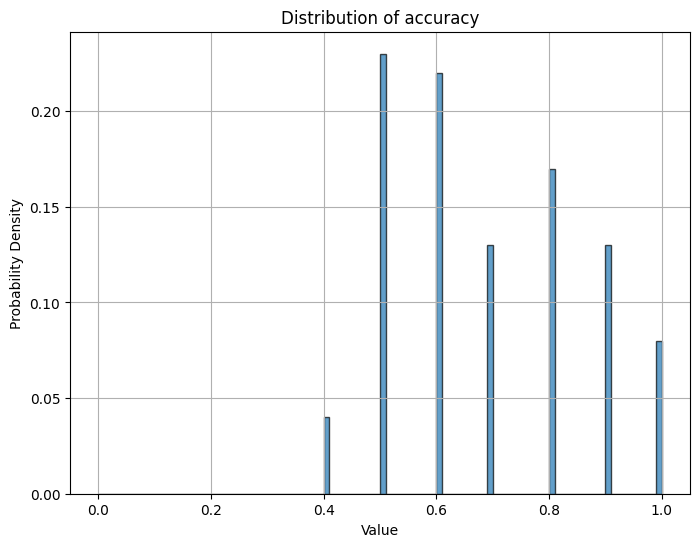

In [9]:
accuracy = get_binary_accuracy(binary_preds, plot_cdf=True, plot_distribution=True)

In [7]:
accuracy_descs = get_accuracy_descs(json_data_binary, include_pos_neg=True, display=True)

(0.4, 0.8, 0.0, 'dates or time-related information')
(0.4, 0.2, 0.6, 'words signaling conflicting or contrasting information')
(0.4, 0.8, 0.0, 'phrases related to legal issues and law enforcement')
(0.4, 0.8, 0.0, 'phrases that are commonly used in research or formal reports')
(0.5,
 1.0,
 0.0,
 'references to locations or events related to the state of Florida')
(0.5, 1.0, 0.0, 'metaphorical expressions related to success and achievement')
(0.5, 1.0, 0.0, 'numbers and financial terms')
(0.5, 0.8, 0.2, 'disparities between genders or races in various aspects')
(0.5, 1.0, 0.0, 'words related to elements from the periodic table')
(0.5, 1.0, 0.0, 'names of specific computer software or platforms')
(0.5, 1.0, 0.0, 'mentions of specific locations, with a focus on New York City')
(0.5,
 0.8,
 0.2,
 'instances where something is considered problematic or controversial')
(0.5, 1.0, 0.0, 'references to email sharing')
(0.5,
 1.0,
 0.0,
 'attributes related to products such as being inexpensive,

### Older things

In [ ]:
def get_predictions(feature_num):
    predictions = predict_activations(feature_num, test_number=10, show_examples=8)
    return predictions

def run():
    data = get_predictions(991) #806
    # for i in range(len(all_data)):
        # data = all_data[i]
        # print(feature_nums[i])
    print()
    pprint.pprint(data)
    custom = custom_accuracy(data)

    print(custom)

    # custom = [custom_accuracy(data, eps = 0.1) for data in all_data]

for _ in range(1):
    run()

TypeError: predict_activations() got an unexpected keyword argument 'test_number'

In [ ]:
feature_nums = [806]#random.sample(range(0, 1000), 10)

def get_predictions(feature_num):
    predictions = predict_activations(feature_num, test_number=10, show_examples=8)
    return predictions


with concurrent.futures.ThreadPoolExecutor() as executor:
    all_data = list(executor.map(get_predictions, feature_nums))

mses = [mse(data, normalize = False) for data in all_data]
nlls = [nll_variant(data) for data in all_data]
l1s = [l1(data, normalize = True) for data in all_data]

# print('l1s', sorted(l1s))
plot_probability_distribution(mses, title = "Distribution of MSEs")
plot_probability_distribution(nlls, title = "Distribution of NLL variant")
plot_probability_distribution(l1s, title = "Distribution of l1s variant")

NameError: name 'concurrent' is not defined

In [ ]:
def custom_accuracy(data):
    eps = max([elem[0] for elem in data]) / 10
    values = []
    for elem in data:
        true, pred = elem
        ## Add eps to avoid zero case
        true, pred = true + eps, pred + eps
        # Scale values
        true, pred = true ** 0.75, pred ** 0.75
        # Calculate difference
        difference = abs(true - pred)
        # Take ratio
        error = difference / max(true, pred)
        
        accuracy = 1 - error
        values.append(accuracy)
    return sum(values)/len(values)

In [ ]:
feature_nums

NameError: name 'feature_nums' is not defined

In [ ]:
def run():
    data = get_predictions(806)
    # for i in range(len(all_data)):
        # data = all_data[i]
        # print(feature_nums[i])
    pprint.pprint(data)
    custom = custom_accuracy(data)
    print(custom)

    # custom = [custom_accuracy(data, eps = 0.1) for data in all_data]

for _ in range(1):
    run()

# plot_probability_distribution(custom, title = "Distribution of custom accuracy")

('You are evaluating an english description of an autoencoder feature. The '
 'description should correspond to sentences which result in high activation. '
 'The english description of the feature is: " past tense verbs"\n'
 'Here are 8 examples of sentences and their corresponding activations:\n'
 ' Example: " economy\'s cooled off enough, but it wasn\'t always so. Back in '
 'the mid", Activation: 19.96\n'
 'Example: " NL<|endoftext|>," Watts said.ĊĊRubio\'s disclosure sheds new '
 'light on his", Activation: 0.00\n'
 'Example: " in their NL<|endoftext|>," Watts said.ĊĊRubio\'s disclosure sheds '
 'new light", Activation: 0.00\n'
 'Example: "ĊĊRubio\'s disclosure sheds new light on his comments in October, '
 'when he", Activation: 0.00\n'
 'Example: " be sure to add a great feel and glitz to any game. These '
 'wonderful futuristic", Activation: 0.00\n'
 'Example: " their NL<|endoftext|>," Watts said.ĊĊRubio\'s disclosure sheds '
 'new light on", Activation: 0.00\n'
 'Example: " of

In [ ]:
analyze_data(all_data)

TypeError: 'int' object is not subscriptable